# *Further Development of DistributedArrays.jl*

## Nick Schickel (Chemical Engineering)

### Outline:

I.  Introduction - Review
    
    A. What is DistributedArrays.jl
    
    B. Star Framework
    
    C. Midterm project results

II. New Work
    
    A. cumprod
    
    B. Identity matrix (eye)

III. Toward more complex functions
    
    A. Motivation - We want to be able to get eigenvalues for DArrays
    
    B. LU decomposition (mostly)
    
    C. Determinant function

IV. Future Work

# Introduction

### DistributedArrays.jl

DistributedArrays.jl is a package designed around the idea of working with extremely large arrays. Those arrays are likely large enough that they surpass the amount of space on a given node or processor. To combat this, the array is broken up into "chunks" of a more manageable size which are then stored on different nodes or processors. Although creating these distributed arrays, or DArrays as they are labeled by their constructors, allow the convenient storage of the data, it is desirable that functionality exist to perform operations on the data similar to one would with standard arrays. 

To that end, the package DistributedArrays.jl has been developed around overloading functions that exist for standard arrays to work on DArrays. Although simply stated, the task is rather difficult, as now information that we typically need for standard functions to work is spread across multiple locations. One idea to assist in creating working functions was to standardize the practice using the Star Framework.

### Star Framework

The star framework is simply a master function that allows the organized transfer of as little information as possible between the master and slave processes. This works via three helper functions that are passed to the star function with the distributed array of interest.

In [1]:
using Images

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in #imread#161(::Array{Any,1}, ::Function, ::String) at ./deprecated.jl:50
 in imread(::String) at ./deprecated.jl:49
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/Nick/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /Users/Nick/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:360
while loading In[2], in expression starting on line 1


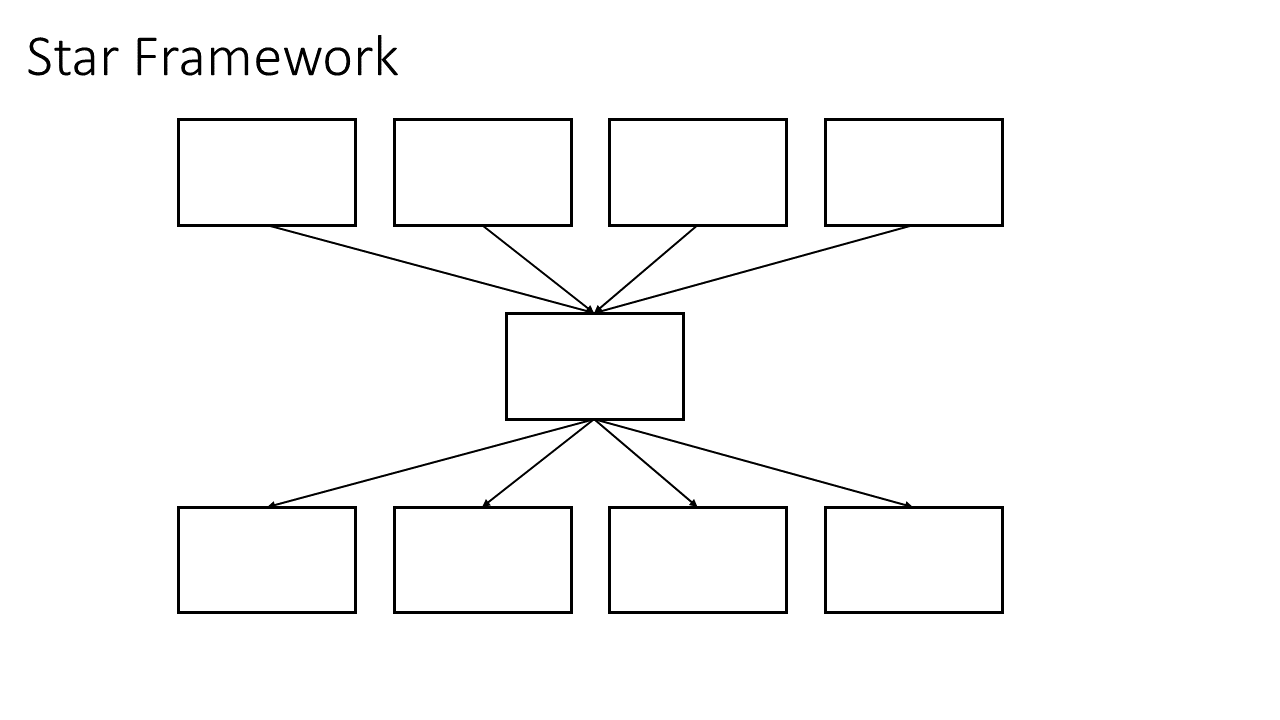

In [2]:
star_image = imread("Generic Star.png")

The helper functions vary in structure depending on what overall operation is desired, but the locations in which they operate are standard. 

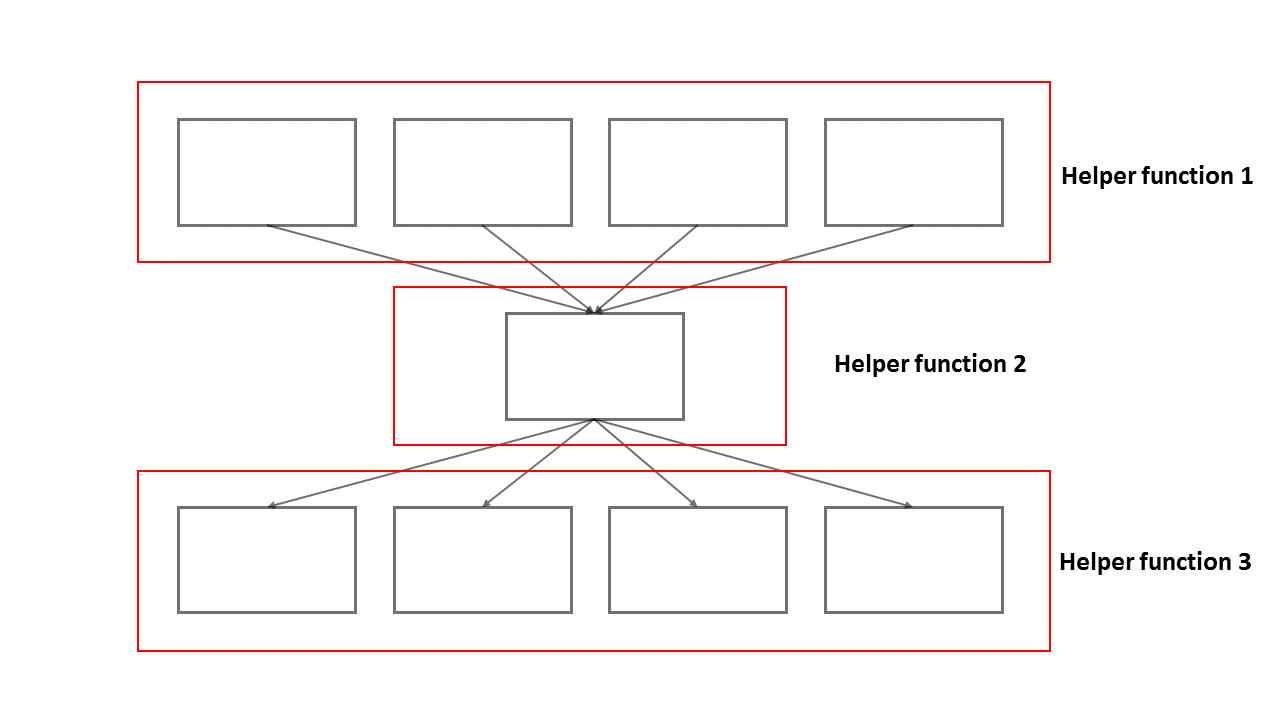

In [3]:
helpers = imread("Helper Function Locations.png")

The first helper function operates in individual chunks of the DArray and outputs some amount of information from each slave processor that is ideally significantly smaller than the individual chunk itself. All of the results of the first helper function are passed to the master processor where the second helper function reads the information, which is stored as Futures, or references to the data locations, and operates on it in the desired way. The second helper function outputs information in segments that are directed to the necessary slave processors by passing its results to the third helper function. Finally, the third helper function uses this information to operate on all of the individual chunks which may be either the same exact values as were passed to the star framework or different values as the result of the first helper function. Helper function three outputs the necessary information to construct a new DArray in the form of futures, which are then used to construct the resulting DArray on the master process.

### Case study: cumsum function

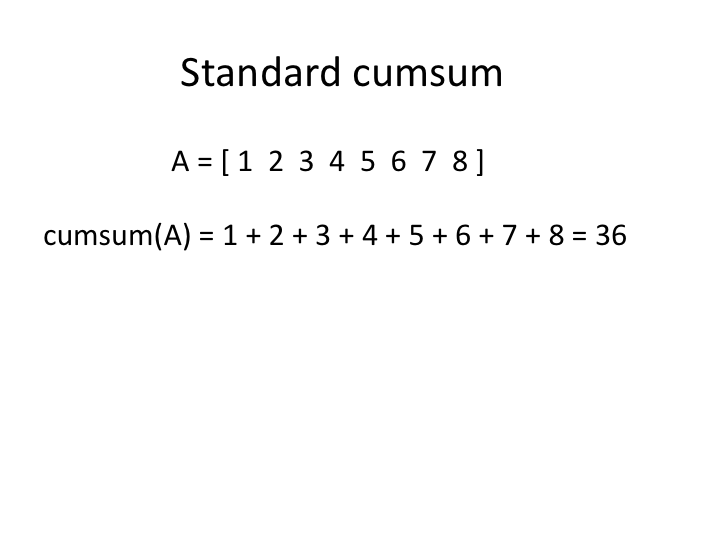

In [4]:
cumsum_image = imread("cumsum.png")

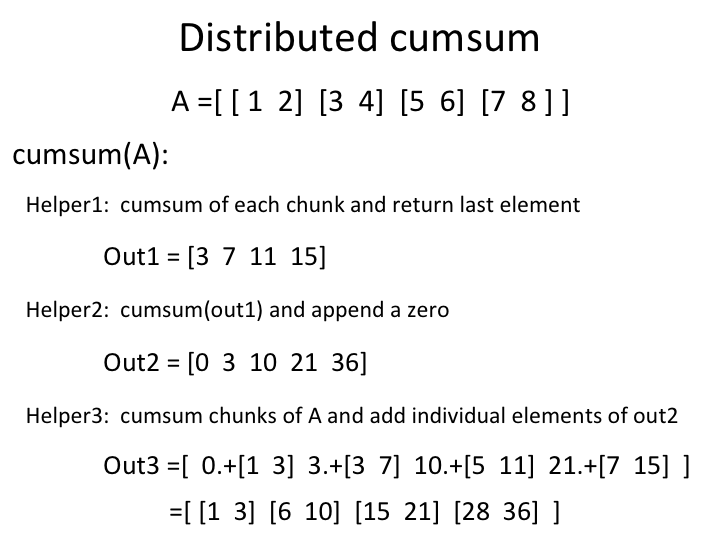

In [5]:
distributed_cumsum = imread("distributed cumsum.png")

### cumsum code

In [ ]:
addprocs(4)

In [14]:
@everywhere using DistributedArrays

In [8]:
function star(f1,f2,f3,args::DistributedArrays.DArray...)
    
    let args = args    
        
        out1 = [remotecall( ()-> f1( DistributedArrays.localpart(args[1]),args[1].indexes ),p ) for p = args[1].pids]

        out2 = f2(fetch.(out1),args[1].indexes)

        out3 = Array(Future,size(args[1].indexes))
            
            for i = 1:length(args[1].pids)
                p = args[1].pids[i]
                out2i = out2[i]
                out3[i] = remotecall( () ->f3( out2i, DistributedArrays.localpart(args[1]), args[1].indexes ),p )
            end
        
        return DArray(out3)
    end
end

star (generic function with 1 method)

In [21]:
@everywhere function cumsum_helper1(A1::AbstractArray,A2::AbstractArray)
    
                if size(A2)[1] == 1 && maximum( [A2[i][1].stop for i = 1:size(A2,2)] ) == 1
                    return cumsum(A1,2)[end]
        
                elseif size(A2)[2] == 1 && maximum( [A2[i][2].stop for i = 1:size(A2,1)] ) == 1
                    return cumsum(A1)[end]
        
                else return cumsum(A1)[size(A1,1),:]'
        
                end
            end


function cumsum_helper2(A::AbstractArray,A2::AbstractArray)          
    if size(A2,1) != size(A,1) && size(A2,2) != size(A,2)
        A = A'
    end
    
    if size(A,1) == 1
        if maximum(size.([A[i] for i = 1:size(A,2)])) == ()
            
            return [0 cumsum(A,2)]  
        else 
            result = []
            
            for i = 1:size(A,2)
                push!(result,zeros(typeof(A[1][1]),size(A[i],2)))
            end
            
            return result
        end
        
    elseif size(A,2) == 1
        
        if maximum(size.([A[i] for i = 1:size(A,1)])) == ()
            return [0; cumsum(A)]
        else 
            return [ [zeros(typeof(A[1][1]),1,size(A[1],2))]; cumsum(A)]
        end
        
    else
        result = []
        for i = 1:size(A,2)
            if size(A[1,i]) == ()
                push!(result,0)
            else
                push!(result,zeros(typeof(A[1][1]),size(A[1,i],2),1))
            end
        end
        
        return [result'; cumsum(A)[1:end-1,:]]
        
    end
end


@everywhere function cumsum_helper3(A1::Any,A2::AbstractArray,A3::AbstractArray)
    
                if size(A3)[1] == 1 && maximum( [A3[i][1].stop for i = 1:size(A3,2)] ) == 1
                    return +(A1,cumsum(A2,2))
                                 
                elseif size(A3)[2] == 1 && maximum( [A3[i][2].stop for i = 1:size(A3,1)] ) == 1
                    return +(A1,cumsum(A2))
                         
                else           
                    result = zeros(typeof(A2[1][1]),size(A2))
                                
                    if size(A3,1) == 1
                        for i = 1:size(A2,1)
                            result[i,:] = +(A1,cumsum(A2)[i,:])
                        end
                        return result

                    elseif size(A3,2) == 1
                        for i = 1:size(A2,1)
                            result[i,:] = +(A1,cumsum(A2)[i,:]')
                        end
                        return result

                    else
                        for i = 1:size(A2,1)
                            result[i,:] = +(A1,cumsum(A2)[i,:]')
                        end
                        return result
                    end
        
                end
            end

In [71]:
ds = dones(4,4)

4×4 DistributedArrays.DArray{Float64,2,Array{Float64,2}}:
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0

In [72]:
cumsum_ds = star(cumsum_helper1,cumsum_helper2,cumsum_helper3,ds)

4×4 DistributedArrays.DArray{Float64,2,Array{Float64,2}}:
 1.0  1.0  1.0  1.0
 2.0  2.0  2.0  2.0
 3.0  3.0  3.0  3.0
 4.0  4.0  4.0  4.0

# New Work 

### cumprod

In [29]:
function star2(f1,f2,f3,args::DistributedArrays.DArray...)
    
    let args = args    
        
        out1 = [remotecall( ()-> f1( DistributedArrays.localpart(args[1]),args[1].indexes ),p ) for p = args[1].pids]

        #println(fetch.(out1))
        
        out2 = f2(fetch.(out1),args[1].indexes)

        #println(out2)
        
        out3 = Array(Future,size(args[1].indexes))
            
            for i = 1:length(args[1].pids)
                p = args[1].pids[i]
                out2i = out2[i]
            #println(out2i)
                out3[i] = remotecall( () ->f3( out2i, DistributedArrays.localpart(args[1]), args[1].indexes ),p )
            end
        #println(fetch.(out3))
        return DArray(out3)
    end
end



@everywhere function cumprod_helper1(A1::AbstractArray,A2::AbstractArray)
    #A1 is the localpart of the original DArray
    #A2 is the array of indexes of the original DArray used to determine size and shape of intermediate results
    
    #if the original DArray is a single "row vector", then simply cumprod over that row and return last value
    if size(A2)[1] == 1 && maximum( [A2[i][1].stop for i = 1:size(A2,2)] ) == 1 
                    return cumprod(A1,2)[end]
     
    #else if the original DArray is a single column vector, then simply cumprod over that column and return last value
    elseif size(A2)[2] == 1 && maximum( [A2[i][2].stop for i = 1:size(A2,1)] ) == 1
                    return cumprod(A1)[end]
    
    #otherwise the original DArray is multi-dimensional, so cumprod over the columns and return the last row
    else 
        return cumprod(A1)[size(A1,1),:]'
        
    end
end



function cumprod_helper2(A::AbstractArray,A2::AbstractArray)
    #A is the result of cumprod_helper1
    #A2 is the array of indexes of the original DArray
    
    #checks if the shape of the result of cumprod_helper1 is correct. If not, transpose the result
    if size(A2,1) != size(A,1) && size(A2,2) != size(A,2)
        A = A'
    end
    
    #if the result of cumprod_helper1 is a single row
    if size(A,1) == 1

        #if the result contains scalar values, then append a one to the beginning of the cumsum of the result
        if maximum(size.([A[i] for i = 1:size(A,2)])) == ()
            
            return [1 cumprod(A,2)]  
            
            #otherwise the result contains vectors, so construct a vector of ones of the correct type and size
        else
            
            result = []
            
            for i = 1:size(A,2)
                push!(result,ones(typeof(A[1][1]),size(A[i],2)))
            end
            
            return result
        end
    
    #else if the result of cumprod_helper1 is a single column
    elseif size(A,2) == 1

        #if the column contains scalars, simply append a one to the front of the cumprod of the column
        if maximum(size.([A[i] for i = 1:size(A,1)])) == ()
            return [1; cumprod(A)]
            
        #otherwise the column contains vectors, so construct a vector of ones to append to the top of the cumprod of the column
        else

            return [ [ones(typeof(A[1][1]),1,size(A[1],2))]; A2AA(cumprod(AA2A(A)),A2)]
        end
    
    #otherwise the result of cumprod_helper1 is a matrix, and the result here is constructed according to the size of the result of cumprod_helper1    
    else

        result = []
        for i = 1:size(A,2)
            if size(A[1,i]) == ()
                push!(result,1)
            else
                push!(result,ones(typeof(A[1][1]),size(A[1,i],2),1))
            end
        end
    
        indexes = Array{typeof(A2[1])}(size(A))
        #println(indexes)
        
        for ii = 1:size(A,1)
        length = 0
            for jj = 1:size(A,2)
                ind1 = ii:ii
                ind2 = (length+1):(length+size(A[ii,jj],2))
                indexes[ii,jj] = (ind1,ind2)
                length += size(A[ii,jj],2)
            end
        end
        
        #return(cumprod(AA2A(A)))
        #return(A2AA(cumprod(AA2A(A)),indexes))
        
        return [result'; A2AA(cumprod(AA2A(A)),indexes)[1:end-1,:]]
        
    end
end




@everywhere function cumprod_helper3(A1::Any,A2::AbstractArray,A3::AbstractArray)
    #A1 is an element of the result of cumprod_helper2 (out2i) which can be a scalar or a vector
    #A2 is the localpart of the original DArray
    #A3 is the array of indexes of the original DArray
    
    # if the original DArray is a single row, then multiply the result of cumprod_helper2 by the cumprod of that row
    if size(A3)[1] == 1 && maximum( [A3[i][1].stop for i = 1:size(A3,2)] ) == 1
            return *(A1,cumprod(A2,2))
    
    #if the original DArray is a single column, then multiply the result of cumprod_helper2 by the cumprod of that column
    elseif size(A3)[2] == 1 && maximum( [A3[i][2].stop for i = 1:size(A3,1)] ) == 1
            return *(A1,cumprod(A2))
    
    #otherwise the original DArray is multi-dimensional, and the result must be constructed according to the size and shape of the indexes    
    else           
            result = ones(typeof(A2[1][1]),size(A2))
                   
            if size(A3,1) == 1
                for i = 1:size(A2,1)
                    result[i,:] = .*(A1,cumprod(AA2A(A2))[i,:])
                end
                    return result

            elseif size(A3,2) == 1
            #return(cumprod(A2)
                #indexes = [(1:size(A2,1), 1:size(A2,2))]
                #temp = cumprod(AA2A(A2))
            
                for i = 1:size(A2,1)
                #return(A1.*temp[i,:]')

                result[i,:] = .*(A1,cumprod(AA2A(A2))[i,:]')
                end
                    return result

            else
                for i = 1:size(A2,1)
                    result[i,:] = .*(A1,cumprod(AA2A(A2))[i,:]')
                end
                    return result
            end
        
    end
end



@everywhere function AA2A(A::AbstractArray)
    #A is an array made up of array elements
    #the output of this function is a new standard array whose total number of 
    #       columns and rows equal the sum of the sizes of all elements in A
    
    rows = 0
    cols = 0
    for ii = 1:size(A,1)
        rows += size(A[ii,1],1)
    end
    for jj = 1:size(A,2)
        cols += size(A[1,jj],2)
    end
    
    A_new = Array{typeof(A[1][1])}(rows,cols)
    
    for i = 1:size(A,1)
        for j = 1:size(A,2)
            for k = 1:size(A[i,j],1)
                for l = 1:size(A[i,j],2)
                    A_new[(i-1)*size(A[i,j],1)+k,(j-1)*size(A[i,j],2)+l] = A[i,j][k,l]
                end
            end
        end
    end
    
    return A_new
    
end



@everywhere function A2AA(A::Array,indexes::Array)
    A_new = Array{typeof(A)}(size(indexes,1),size(indexes,2))
    if size(indexes,1) == 1 && size(indexes,2) == 1
        A_new = A
    else
        for i = 1:size(indexes,1)
            for j = 1:size(indexes,2)
                A_new[i,j] = A[indexes[i,j][1].start:indexes[i,j][1].stop,indexes[i,j][2].start:indexes[i,j][2].stop]
            end
        end
    end
    return A_new
end


In [27]:
ds2 = 2*dones((4,4),workers()[1:4],[2,2])

4×4 DistributedArrays.DArray{Float64,2,Array{Float64,2}}:
 2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0

In [30]:
cumprod_ds2 = star2(cumprod_helper1,cumprod_helper2,cumprod_helper3,ds2)

4×4 DistributedArrays.DArray{Float64,2,Array{Float64,2}}:
  2.0   2.0   2.0   2.0
  4.0   4.0   4.0   4.0
  8.0   8.0   8.0   8.0
 16.0  16.0  16.0  16.0

### distributed identity matrix

In [33]:
function deye(n::Int)
    J = dzeros(n,n)
    let J = J
        #println(J.indexes)
        out1 = [remotecall( () -> eye_helper(localpart(J), J.indexes, p), p) for p = J.pids]
        #println(fetch.(out1))
    return DArray(out1)
        
    end
end



@everywhere function eye_helper(A1::AbstractArray,A2::AbstractArray,p::Int)
    #A1 is the local chunk
    #A2 is the array of indexes
    #p is the current process
    
    for i = 1:(A2[p-1][1].stop-A2[p-1][1].start+1)
        for j = 1:(A2[p-1][2].stop-A2[p-1][2].start+1)
            if (i - 1 + A2[p-1][1].start) == (j - 1 + A2[p-1][2].start)
                A1[i,j] = one(typeof(A1[1,1]))
            end
        end
    end
    return A1
end

In [34]:
deye(3)

3×3 DistributedArrays.DArray{Float64,2,Array{Float64,2}}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

# More complex functions

Although functions such as cumsum, cumprod, eye, etc. arent' necessarily that difficult to write and do give a good idea of what the star framework was designed for, they don't really provide the most utility in the long run. What would really help develop DistributedArrays.jl would be a function to find the eigenvalues or singular values of a DArray. These functions, and those that are needed to write them, don't yet exist in the package.

### Finding eigenvalues

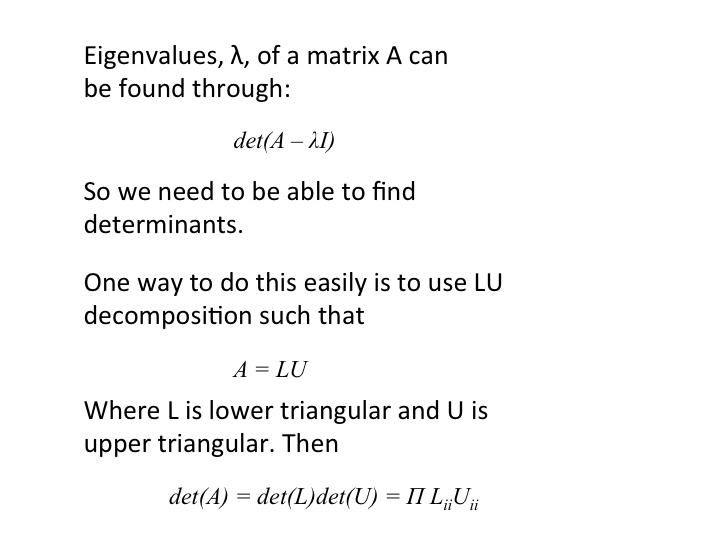

In [69]:
LU_decomp = imread("LU decomp.png")

### LU decomposition

In [49]:
@everywhere function getParents(current_chunk::AbstractArray,indexes::AbstractArray,current_pid::Int) #must be run on all chunks
    if indexes[current_pid-1][1].start == 1 #then this chunk includes first row of parrent array
        parent_vec = current_chunk[1,1]
        if size(current_chunk,2) > 1
            for i = 2:size(current_chunk,2)
                parent_vec = [parent_vec current_chunk[1,i]]'
            end
        end
        return parent_vec
    end
end



@everywhere function LFactors(current_chunk,indexes,current_pid,parent_vec)
    #indices = Array{Tuple{Int64}{Int64}}(size(current_chunk))
    
    #if indexes[current_pid-1]
    LFactors = Array{typeof(current_chunk[1,1])}(size(current_chunk))
        
    for i = 1:(indexes[current_pid-1][1].stop - indexes[current_pid-1][1].start + 1)
        
        for j = 1:(indexes[current_pid-1][2].stop - indexes[current_pid-1][2].start + 1)
            
            #indices[i,j] = (i - 1 + indexes[current_pid-1][1].start, j - 1 + indexes[current_pid-1][2].start)
            
            if (i - 1 + indexes[current_pid-1][1].start) == (j - 1 + indexes[current_pid-1][2].start)
                
                LFactors[i,j] = 1
                
            elseif (i - 1 + indexes[current_pid-1][1].start) > (j - 1 + indexes[current_pid-1][2].start)                
                
                
                LFactors[i,j] = (current_chunk[i,j] / parent_vec[j]) - sum(LFactors[i,1:i-1])
            else
                
                LFactors[i,j] = 0            
            end
        end
    end
    
    return LFactors
end




@everywhere function ConstructU(current_chunk,indexes,current_pid,parent_vec,LFacts)
    
    UFactors = Array{typeof(current_chunk[1][1])}(size(current_chunk))

    for i = 1:(indexes[current_pid-1][1].stop - indexes[current_pid-1][1].start + 1)
        
        for j = 1:(indexes[current_pid-1][2].stop - indexes[current_pid-1][2].start + 1)
            
            if (i - 1 + indexes[current_pid-1][1].start) == 1
                
                UFactors[i,j] = current_chunk[i,j]
                
            elseif (i - 1 + indexes[current_pid-1][1].start) <= (j - 1 + indexes[current_pid-1][2].start)                
                #if (i - 1 + indexes[current_pid-1][1].start) == 2 && (j - 1 + indexes[current_pid-1][2].start) == 2
                    #return [current_chunk[i,j] parent_vec[j] LFacts[i,:]]
                #end
                sum = 0
                for ii = 1:i-1
                    sum += LFacts[i,ii]*UFactors[ii,j]
                end
                UFactors[i,j] = current_chunk[i,j] - sum  #parent_vec[j-1+indexes[current_pid-1][2].start]
            else
                UFactors[i,j] = 0
                
            end
        end
    end
    
    return UFactors
end



In [45]:
ds3 = DArray((3,3),workers()[1:3],[1,3]) do I
    rand(1:10,map(length,I)...)
end

3×3 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
 5  9  4
 7  1  7
 2  9  6

In [46]:
ds3 = ds3 + [0 -2 4; 3 16 11; 13 15 21]

3×3 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
  5   7   8
 10  17  18
 15  24  27

In [73]:
function dLU(getParents,LFactors,ConstructU,ds3)  
let ds3 = ds3
    
    out1 = [remotecall( ()-> getParents(localpart(ds3), ds3.indexes, p), p ) for p = ds3.pids[1,:]]
    parent_vec = AA2A(fetch.(out1)')
    #display(parent_vec)
    
    #out2 = [remotecall( () -> LFactors(localpart(ds3), ds3.indexes, p, parent_vec), p) for p = ds3.pids]
    #LFacts = AA2A(fetch.(out2))
    LFacts = [1 0 0; 2 1 0; 3 1 1]
    display(LFacts)
    
    out3 = [remotecall( () -> ConstructU(localpart(ds3), ds3.indexes, p, parent_vec, LFacts), p) for p = ds3.pids]
    #display(AA2A(fetch.(out3)))
    UFacts = AA2A(fetch.(out3))
    display(UFacts)
    
    display(LFacts*UFacts)
    
    #display(ds3)
end
end

dLU (generic function with 2 methods)

In [74]:
LU_ds3 = dLU(getParents,LFactors,ConstructU,ds3)

3×3 Array{Int64,2}:
 1  0  0
 2  1  0
 3  1  1

3×3 Array{Int64,2}:
 5  7  8
 0  3  2
 0  0  1

3×3 Array{Int64,2}:
  5   7   8
 10  17  18
 15  24  27

In [68]:
ds3

3×3 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
  5   7   8
 10  17  18
 15  24  27

### Determinants

In [36]:
function d_det(D::DistributedArrays.DArray...)

    let D = D
        #println(J.indexes)
        out1 = [remotecall( () -> det_helper(localpart(D[1]), D[1].indexes, p), p) for p = D[1].pids]
        #println(fetch.(out1))
        
        diagprod = AA2A(fetch.(out1))
        
        return prod(diagprod)
        
    end
end



@everywhere function det_helper(A1::AbstractArray,A2::AbstractArray,p)
    #A1 is the local chunk
    #A2 is the array of indexes
    #p is the current process
    diag_prod = 1
    for i = 1:(A2[p-1][1].stop-A2[p-1][1].start+1)
        for j = 1:(A2[p-1][2].stop-A2[p-1][2].start+1)
            if (i - 1 + A2[p-1][1].start) == (j - 1 + A2[p-1][2].start)
                diag_prod *= A1[i,j]
            end
        end
    end
    return diag_prod
end

In [37]:
ds4 = 2*deye(3)

3×3 DistributedArrays.DArray{Float64,2,Array{Float64,2}}:
 2.0  0.0  0.0
 0.0  2.0  0.0
 0.0  0.0  2.0

In [38]:
d_det(ds4)

8.0

# Future Work

#### -fix LU decomposition code to generalize it and be able to calculate the L-factors successfully
#### -optimize working code to reduce overhead where possible 
#### -write code to determine eigenvalues
#### -push all code to DistributedArrays.jl on github and submit pull request